# Task 9 – Model-based swing-up planning

This notebook estimates the pendulum parameters (\(\alpha_1,\alpha_2\)) from recorded demonstrations and builds a CasADi-based swing-up planner that mirrors Section 6 of Atkeson & Schaal (1997).

In [1]:
import os
import sys
from pathlib import Path

current = Path.cwd()
if (current / 'notebooks').exists():
    PROJECT_ROOT = current
else:
    PROJECT_ROOT = current.parent

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)

Project root: /home/acepeax/Desktop/Studies/MVA/Robotics/Project


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca


from scripts.task_7_env import Task7PendulumEnv, Y_MAX

pybullet build time: Dec  4 2025 20:11:42


In [3]:
DATA_DIR = Path('data')
MANUAL_DATA_DIR = DATA_DIR / 'task8_manual'
DEFAULT_RECORDING = DATA_DIR / 'swing_up_demo.npz'
SIM_SUBSTEPS = 6  # must match the recording
BASE_DT = 1.0 / 240.0
STEP_DT = BASE_DT * SIM_SUBSTEPS
GRAVITY = 9.81

def _latest_manual_recording():
    recordings = sorted(MANUAL_DATA_DIR.glob('task8_*.npz'))
    return recordings[-1] if recordings else None

print('Using step dt =', STEP_DT)

Using step dt = 0.025


In [4]:
def load_recording(record_file=None):
    if record_file is None:
        if DEFAULT_RECORDING.exists():
            record_file = DEFAULT_RECORDING
        else:
            record_file = _latest_manual_recording()
            if record_file is None:
                raise FileNotFoundError('No recording found in ' + str(MANUAL_DATA_DIR))
    record_file = Path(record_file)
    data = np.load(record_file)
    observations = np.asarray(data['observations'], dtype=np.float64)
    actions = np.asarray(data['actions'], dtype=np.int32)
    rewards = np.asarray(data['rewards'], dtype=np.float64)
    print('Loaded', record_file, 'with', len(actions), 'steps')
    return record_file, observations, actions, rewards

In [ ]:
def estimate_pendulum_params(observations, step_dt=STEP_DT):
    theta = observations[:, 0]
    theta_dot = observations[:, 1]
    ee_vel_y = observations[:, 12]
    hand_acc = np.gradient(ee_vel_y, step_dt)
    delta = (theta_dot[1:] - theta_dot[:-1]) / step_dt
    phi = np.stack([
        np.sin(theta[:-1]),                 # gravity term
        theta_dot[:-1],                     # damping term
        hand_acc[:-1] * np.cos(theta[:-1])  # coupling term
    ], axis=1)
    coeffs, residuals, _, _ = np.linalg.lstsq(phi, delta, rcond=None)
    alpha1, alpha2 = coeffs
    residual = residuals[0] if residuals.size else np.sum((phi @ coeffs - delta) ** 2)
    rmse = np.sqrt(residual / len(delta))
    return alpha1, alpha2, rmse

In [6]:
record_file, observations, actions, rewards = load_recording(record_file="data/swing_up_demo.npz")
alpha1, alpha2, rmse = estimate_pendulum_params(observations)
print(f'Estimated alpha1={alpha1:.4f}, alpha2={alpha2:.4f}, velocity RMSE={rmse:.4f}')

Loaded data/swing_up_demo.npz with 86 steps
Estimated alpha1=-0.0044, alpha2=0.7298, velocity RMSE=0.3198


In [ ]:
def plan_swing_up(
    alpha1,
    alpha2,
    horizon_steps=320,
    step_dt=STEP_DT,
    y_limit=0.55,
    y_vel_limit=4.0,
    start_state=None,
    weights=None,
    initial_guess=None,
):
    if start_state is None:
        start_state = np.array([-np.pi + 0.05, 0.0, 0.0, 0.0], dtype=float)
    if weights is None:
        weights = {
            'theta': 3.0,
            'theta_dot': 0.5,
            'y': 1.5,
            'y_dot': 0.2,
            'u': 0.001,
            'terminal_theta': 20.0,
            'terminal_theta_dot': 2.0,
        }
    opti = ca.Opti()
    X = opti.variable(4, horizon_steps + 1)
    U = opti.variable(1, horizon_steps)
    opti.subject_to(X[:, 0] == start_state.reshape(-1, 1))
    cost = 0
    for k in range(horizon_steps):
        theta = X[0, k]
        theta_dot = X[1, k]
        y = X[2, k]
        y_dot = X[3, k]
        u = U[0, k]
        theta_ddot = alpha1 * ca.sin(theta) + alpha2 * theta_dot + u * ca.cos(theta)
        theta_dot_next = theta_dot + step_dt * theta_ddot
        theta_next = theta + step_dt * theta_dot_next
        y_next = y + step_dt * y_dot_next
        state_next = ca.vertcat(theta_next, theta_dot_next, y_next, y_dot_next)
        opti.subject_to(X[:, k + 1] == state_next)
        opti.subject_to(opti.bounded(-y_limit, y_next, y_limit))
        opti.subject_to(opti.bounded(-y_vel_limit, y_dot_next, y_vel_limit))
        cost += (
            weights['theta'] * theta_next**2
            + weights['theta_dot'] * theta_dot_next**2
            + weights['y'] * y_next**2
            + weights['y_dot'] * y_dot_next**2
            + weights['u'] * u**2
        )
    theta_T = X[0, -1]
    theta_dot_T = X[1, -1]
    cost += weights['terminal_theta'] * theta_T**2 + weights['terminal_theta_dot'] * theta_dot_T**2
    opti.minimize(cost)
    if initial_guess is not None:
        X_guess, U_guess = initial_guess
        if X_guess.shape == (4, horizon_steps + 1):
            opti.set_initial(X, X_guess)
        if U_guess.shape == (1, horizon_steps):
            opti.set_initial(U, U_guess)
    opti.solver('ipopt', {'ipopt.print_level': 0, 'print_time': False})
    sol = opti.solve()
    result = {
        'theta': np.array(sol.value(X[0, :])).flatten(),
        'theta_dot': np.array(sol.value(X[1, :])).flatten(),
        'y': np.array(sol.value(X[2, :])).flatten(),
        'y_dot': np.array(sol.value(X[3, :])).flatten(),
        'u': np.array(sol.value(U[0, :])).flatten(),
        'step_dt': step_dt,
    }
    return result

In [8]:
def build_initial_guess_from_demo(observations, horizon_steps, step_dt=STEP_DT):
    def _resample(array, target_len):
        if len(array) == target_len:
            return array.astype(float)
        src = np.linspace(0.0, 1.0, len(array))
        tgt = np.linspace(0.0, 1.0, target_len)
        return np.interp(tgt, src, array)
    theta = observations[:, 0]
    theta_dot = observations[:, 1]
    ee_y = observations[:, 9]
    ee_y_dot = observations[:, 12]
    ee_y_ddot = np.gradient(ee_y_dot, step_dt)
    theta_samples = _resample(theta, horizon_steps + 1)
    theta_dot_samples = _resample(theta_dot, horizon_steps + 1)
    y_samples = _resample(ee_y, horizon_steps + 1)
    y_dot_samples = _resample(ee_y_dot, horizon_steps + 1)
    X_guess = np.vstack([
        theta_samples,
        theta_dot_samples,
        y_samples,
        y_dot_samples,
    ])
    U_guess = _resample(ee_y_ddot, horizon_steps).reshape(1, -1)
    start_state = X_guess[:, 0]
    return start_state, X_guess, U_guess

In [9]:
horizon = 320
start_state, X_guess, U_guess = build_initial_guess_from_demo(observations, horizon)
plan = plan_swing_up(
    alpha1,
    alpha2,
    horizon_steps=horizon,
    y_limit=0.55,
    y_vel_limit=4.0,
    start_state=start_state,
    weights={
        'theta': 3.0,
        'theta_dot': 0.5,
        'y': 1.5,
        'y_dot': 0.2,
        'u': 0.001,
        'terminal_theta': 20.0,
        'terminal_theta_dot': 2.0,
    },
    initial_guess=(X_guess, U_guess),
)
print('Planned horizon duration:', len(plan['u']) * STEP_DT, 's')


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Planned horizon duration: 8.0 s


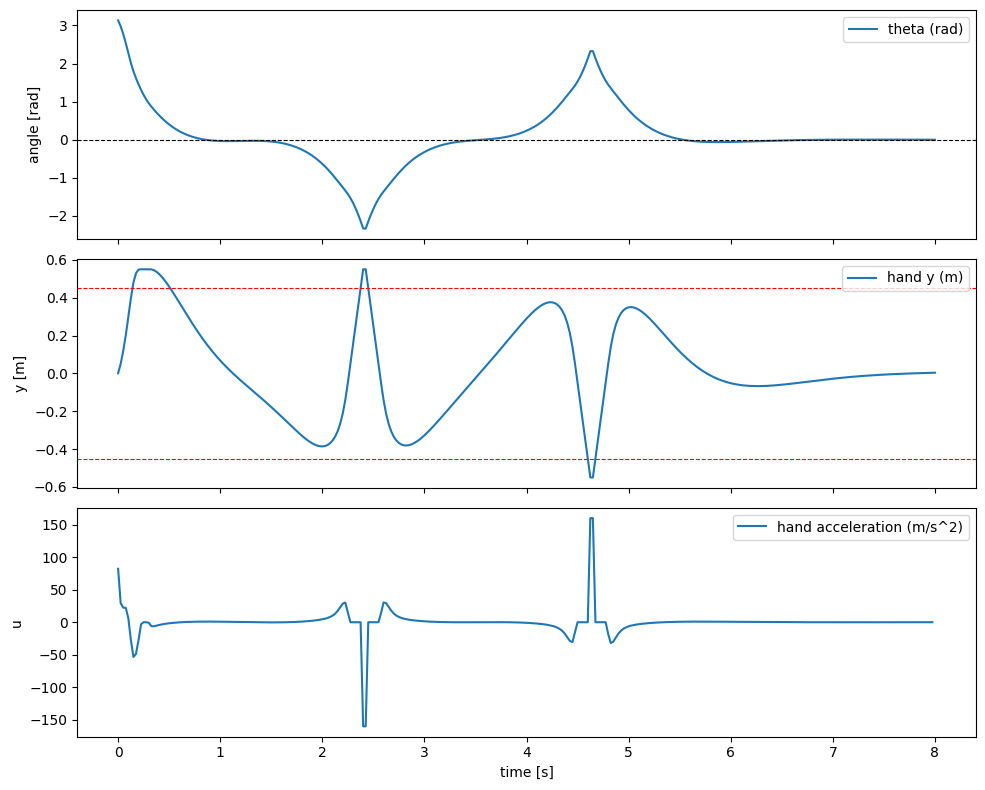

In [10]:
def plot_plan(plan):
    t = np.arange(len(plan['theta'])) * plan['step_dt']
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    axs[0].plot(t, plan['theta'], label='theta (rad)')
    axs[0].axhline(0, color='k', linestyle='--', linewidth=0.8)
    axs[0].set_ylabel('angle [rad]')
    axs[0].legend()
    axs[1].plot(t, plan['y'], label='hand y (m)')
    axs[1].axhline(Y_MAX, color='r', linestyle='--', linewidth=0.8)
    axs[1].axhline(-Y_MAX, color='r', linestyle='--', linewidth=0.8)
    axs[1].set_ylabel('y [m]')
    axs[1].legend()
    axs[2].plot(t[:-1], plan['u'], label='hand acceleration (m/s^2)')
    axs[2].set_ylabel('u')
    axs[2].set_xlabel('time [s]')
    axs[2].legend()
    fig.tight_layout()
    return fig, axs

plot_plan(plan);

In [11]:
def rollout_plan_in_env(plan, gui=False):
    env = Task7PendulumEnv(gui=gui, should_balance=False, sim_substeps=SIM_SUBSTEPS)
    env.set_initial_pendulum_angle(0)
    obs, _ = env.reset()
    actions = []
    rewards = []
    for u in plan['u']:
        target = np.clip(np.sign(u), -1.0, 1.0)
        if target > 0.1:
            action = 2  # maps to +Y_MAX
        elif target < -0.1:
            action = 0  # maps to -Y_MAX
        else:
            action = 1  # stay
        obs, reward, terminated, _, info = env.step(action)
        actions.append(action)
        rewards.append(reward)
        if terminated:
            break
    env.close()
    return np.array(actions), np.array(rewards)

# Example (runs headless)
rollout_actions, rollout_rewards = rollout_plan_in_env(plan, gui=True)
print('Rollout length:', len(rollout_actions))

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubunt